#0 Preparations

Installing required packages


In [ ]:
!pip install -r requirements.txt

Import required packages

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import string
import warnings


from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sqlalchemy import create_engine

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# 1 Connect to SQL DB and download data

Init function to load large amount of data from sql db

In [ ]:
def batch_load_sql(query: str, engine) -> pd.DataFrame:
    CHUNKSIZE = 200000
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

Create connection and download data from sql db

In [ ]:
engine = create_engine('###')


user_data = batch_load_sql('SELECT * FROM public.user_data', engine=engine)

post_text_df = batch_load_sql('SELECT * FROM public.post_text_df', engine=engine)

feed_data = pd.read_sql('SELECT * FROM public.feed_data LIMIT 2000000', con=engine)


In [ ]:
user_data

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [ ]:
post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


# 2 Prepare user_data dataframe

Check the data for NA values

In [ ]:
user_data.to_sql('a_cherepaschuk_user_features_lesson_22', con=engine, if_exists='replace') # write table

205

# 3 Text preprocessing and TF-IDF

Init data cleaning and lemmatize tokenizer and make TF-IDF vector

In [ ]:
snowball = WordNetLemmatizer()
english_stop_words = stopwords.words("english")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="english")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in english_stop_words]
    tokens = [snowball.lemmatize(i) for i in tokens]
    return tokens

vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

features = vectorizer.fit_transform(post_text_df['text']).toarray()


In [ ]:
features = pd.DataFrame(
    features,
    index=post_text_df['post_id'],
    columns=vectorizer.get_feature_names_out()
)
features.head()

,"+10,219",+14,+214,"+3,328","+36,128",+429,+44,"+48,472",+49,"+5,297",...,🤬,🤭,🤲👍,🦠,🦠now,🦠🇮🇳,🦠🦠…,🧙🏼‍♀️,🧼wash,🩸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Extract new features from TF-IDF vector

In [ ]:
post_info = post_text_df.copy()
post_info['total_tf_idf'] = features.sum(axis=1).reset_index()[0]
post_info['max_tf_idf'] = features.max(axis=1).reset_index()[0]
post_info['mean_tf_idf'] = features.mean(axis=1).reset_index()[0]

Reduce dimesionality of TF-IDF with PCA

In [ ]:
centered = features - features.mean()
pca = PCA(n_components=100)
pca_data = pca.fit_transform(centered)

Get features

In [ ]:
pca_columns = ["PCA_"+str(i) for i in range(1,101)]

pca_data = pd.DataFrame(data=pca_data, columns=pca_columns)
pca_data

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_91,PCA_92,PCA_93,PCA_94,PCA_95,PCA_96,PCA_97,PCA_98,PCA_99,PCA_100
0,-0.091272,0.155120,-0.043872,-0.105417,-0.124385,-0.211695,-0.093212,0.018142,-0.170820,-0.010876,...,-0.002657,0.005562,-0.042035,0.017038,-0.016012,-0.010434,0.000198,-0.022126,-0.001179,0.039312
1,-0.085483,0.188298,0.052697,0.016779,-0.030278,-0.041058,0.013627,-0.007908,-0.014216,-0.002205,...,-0.020364,0.024091,0.024993,0.019446,0.071175,0.052567,0.019545,-0.012798,0.010569,0.103909
2,-0.071080,0.111950,-0.048973,-0.103776,-0.124782,-0.159147,-0.085231,0.008702,-0.032581,-0.002599,...,0.028621,-0.010926,0.024380,0.019114,0.015458,0.023880,0.055928,-0.058704,-0.013038,-0.054171
3,-0.087481,0.080478,-0.020576,-0.063637,-0.097023,-0.075073,-0.033418,-0.010173,0.045463,-0.010482,...,0.043635,-0.008287,0.019188,0.037839,0.017687,0.007449,0.021080,0.002922,-0.045671,-0.007897
4,-0.061835,0.049885,-0.018426,-0.036757,-0.036832,-0.027569,0.006055,0.010647,0.060452,0.004306,...,0.013896,-0.007354,-0.003397,0.000159,0.004652,-0.001135,0.009723,0.013952,-0.016063,0.038900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,0.184275,-0.034388,0.124961,-0.074028,-0.000966,0.001785,0.006621,0.003812,-0.007564,-0.006995,...,0.009690,0.021531,-0.007323,-0.027773,-0.050247,0.030591,0.067521,0.049295,0.006600,-0.033055
7019,0.151259,-0.029902,0.079653,-0.044432,-0.022141,-0.002320,0.019461,-0.014737,-0.018340,0.003782,...,0.035360,-0.030219,0.008088,0.036895,-0.019104,-0.058861,-0.034615,-0.042666,0.045102,-0.011732
7020,0.073582,-0.024775,-0.078047,0.100995,-0.020578,0.009540,-0.034395,-0.027870,0.002227,0.004752,...,-0.001614,0.019013,0.017852,0.012296,0.001596,-0.005961,0.024934,0.008177,-0.005485,0.001885
7021,0.075233,-0.001864,-0.072270,0.079246,-0.019496,0.001359,-0.003952,-0.007741,-0.005150,0.003870,...,-0.005160,-0.017933,0.013990,0.002047,-0.003513,-0.008164,0.019326,0.003739,-0.004955,0.011899


# 4 Prepare final dataset

In [ ]:
post_info = pd.concat((post_info, pca_data), axis=1)
post_info

,post_id,text,topic,total_tf_idf,max_tf_idf,mean_tf_idf,PCA_1,PCA_2,PCA_3,PCA_4,...,PCA_91,PCA_92,PCA_93,PCA_94,PCA_95,PCA_96,PCA_97,PCA_98,PCA_99,PCA_100
0,1,UK economy facing major risks\n\nThe UK manufa...,business,9.412852,0.477866,0.000158,-0.091272,0.155120,-0.043872,-0.105417,...,-0.002657,0.005562,-0.042035,0.017038,-0.016012,-0.010434,0.000198,-0.022126,-0.001179,0.039312
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,12.846987,0.245499,0.000216,-0.085483,0.188298,0.052697,0.016779,...,-0.020364,0.024091,0.024993,0.019446,0.071175,0.052567,0.019545,-0.012798,0.010569,0.103909
2,3,Asian quake hits European shares\n\nShares in ...,business,13.383601,0.256425,0.000225,-0.071080,0.111950,-0.048973,-0.103776,...,0.028621,-0.010926,0.024380,0.019114,0.015458,0.023880,0.055928,-0.058704,-0.013038,-0.054171
3,4,India power shares jump on debut\n\nShares in ...,business,6.707371,0.529312,0.000113,-0.087481,0.080478,-0.020576,-0.063637,...,0.043635,-0.008287,0.019188,0.037839,0.017687,0.007449,0.021080,0.002922,-0.045671,-0.007897
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.478985,0.412921,0.000109,-0.061835,0.049885,-0.018426,-0.036757,...,0.013896,-0.007354,-0.003397,0.000159,0.004652,-0.001135,0.009723,0.013952,-0.016063,0.038900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,7.208761,0.257277,0.000121,0.184275,-0.034388,0.124961,-0.074028,...,0.009690,0.021531,-0.007323,-0.027773,-0.050247,0.030591,0.067521,0.049295,0.006600,-0.033055
7019,7316,I give this movie 2 stars purely because of it...,movie,7.262576,0.365120,0.000122,0.151259,-0.029902,0.079653,-0.044432,...,0.035360,-0.030219,0.008088,0.036895,-0.019104,-0.058861,-0.034615,-0.042666,0.045102,-0.011732
7020,7317,I cant believe this film was allowed to be mad...,movie,6.146129,0.538860,0.000103,0.073582,-0.024775,-0.078047,0.100995,...,-0.001614,0.019013,0.017852,0.012296,0.001596,-0.005961,0.024934,0.008177,-0.005485,0.001885
7021,7318,The version I saw of this film was the Blockbu...,movie,7.470195,0.219498,0.000125,0.075233,-0.001864,-0.072270,0.079246,...,-0.005160,-0.017933,0.013990,0.002047,-0.003513,-0.008164,0.019326,0.003739,-0.004955,0.011899


In [ ]:
post_info.to_sql('a_cherepaschuk_post_features_main_lesson_22', con=engine, if_exists='replace') # write table

23

Extract features from timestamp

In [ ]:
feed_data['timestamp'] = pd.to_datetime(feed_data['timestamp'])

feed_data['hour'] = feed_data['timestamp'].apply(lambda x: x.hour)
feed_data['month'] = feed_data['timestamp'].apply(lambda x: x.month)

In [ ]:
final_dataset = pd.merge(feed_data, post_info, how='left', on='post_id')
final_dataset.head(5)

,timestamp,user_id,post_id,action,target,hour,month,text,topic,total_tf_idf,...,PCA_91,PCA_92,PCA_93,PCA_94,PCA_95,PCA_96,PCA_97,PCA_98,PCA_99,PCA_100
0,2021-12-18 12:44:13,109250,3784,view,0,12,12,"Baahubali director, SS Rajamouli, tests positi...",covid,2.978999,...,-0.003026,0.004992,-0.026518,-0.029261,0.011092,-0.008326,0.015852,-0.000747,-0.013525,-0.016712
1,2021-12-18 12:45:06,109250,647,view,0,12,12,Lee to create new film superhero\n\nComic book...,entertainment,8.855845,...,0.015455,0.001694,-0.005051,-0.011901,0.011231,-0.013819,-0.013966,-0.015236,-0.005370,-0.036510
2,2021-12-18 12:47:24,109250,3380,view,0,12,12,Y’day went for physio. Appalled many folk in #...,covid,3.634762,...,0.004317,-0.011606,0.006850,0.004729,-0.003734,0.015920,0.014572,0.016077,-0.010183,0.019946
3,2021-12-18 12:49:41,109250,4860,view,0,12,12,Anne Christie was Garbos 14th film and the fir...,movie,8.110076,...,-0.006145,-0.013602,-0.020249,-0.009647,-0.017199,0.001254,-0.041161,-0.032551,-0.004512,0.036747
4,2021-12-18 12:51:15,109250,4644,view,0,12,12,I first saw the trailer for Frailty on Yahoo M...,movie,7.836047,...,0.030234,-0.035232,0.041785,0.033415,0.025658,0.024345,0.002506,-0.008398,0.002621,0.037893


In [ ]:
final_dataset = pd.merge(final_dataset, user_data, how='left', on='user_id')
final_dataset.head(5)

,timestamp,user_id,post_id,action,target,hour,month,text,topic,total_tf_idf,...,PCA_98,PCA_99,PCA_100,gender,age,country,city,exp_group,os,source
0,2021-12-18 12:44:13,109250,3784,view,0,12,12,"Baahubali director, SS Rajamouli, tests positi...",covid,2.978999,...,-0.000747,-0.013525,-0.016712,1,56,Ukraine,Ananiv,4,Android,organic
1,2021-12-18 12:45:06,109250,647,view,0,12,12,Lee to create new film superhero\n\nComic book...,entertainment,8.855845,...,-0.015236,-0.005370,-0.036510,1,56,Ukraine,Ananiv,4,Android,organic
2,2021-12-18 12:47:24,109250,3380,view,0,12,12,Y’day went for physio. Appalled many folk in #...,covid,3.634762,...,0.016077,-0.010183,0.019946,1,56,Ukraine,Ananiv,4,Android,organic
3,2021-12-18 12:49:41,109250,4860,view,0,12,12,Anne Christie was Garbos 14th film and the fir...,movie,8.110076,...,-0.032551,-0.004512,0.036747,1,56,Ukraine,Ananiv,4,Android,organic
4,2021-12-18 12:51:15,109250,4644,view,0,12,12,I first saw the trailer for Frailty on Yahoo M...,movie,7.836047,...,-0.008398,0.002621,0.037893,1,56,Ukraine,Ananiv,4,Android,organic


In [ ]:
final_dataset = final_dataset.drop(['text', 'action', 'exp_group'], axis=1)

In [ ]:
final_dataset = final_dataset.set_index(['user_id', 'post_id'])

In [ ]:
final_dataset

timestamp  target  hour  month          topic  \
user_id post_id                                                           
109250  3784    2021-12-18 12:44:13       0    12     12          covid   
        647     2021-12-18 12:45:06       0    12     12  entertainment   
        3380    2021-12-18 12:47:24       0    12     12          covid   
        4860    2021-12-18 12:49:41       0    12     12          movie   
        4644    2021-12-18 12:51:15       0    12     12          movie   
...                             ...     ...   ...    ...            ...   
14951   1776    2021-12-08 22:30:55       0    22     12          sport   
        1331    2021-12-08 22:33:45       0    22     12       politics   
        2542    2021-12-08 22:34:24       0    22     12          covid   
        6923    2021-12-08 22:35:30       0    22     12          movie   
        2033    2021-12-08 22:36:24       1    22     12           tech   

                 total_tf_idf  max_tf_idf  mean_tf_idf     PCA_1     PCA_2  \
user_id post_id                                                              
109250  3784         2.978999    0.641756     0.000050 -0.115251 -0.106377   
        647          8.855845    0.374358     0.000149  0.053670  0.032022   
        3380         3.634762    0.349394     0.000061 -0.090660 -0.079647   
        4860         8.110076    0.388752     0.000136  0.069279 -0.004276   
        4644         7.836047    0.328196     0.000132  0.123079 -0.012008   
...                       ...         ...          ...       ...       ...   
14951   1776         8.707759    0.362910     0.000146 -0.041772  0.054781   
        1331         8.698690    0.461030     0.000146 -0.045717  0.108134   
        2542         3.452304    0.438994     0.000058 -0.100353 -0.091552   
        6923         6.882490    0.266153     0.000116  0.011242 -0.003230   
        2033        10.279514    0.329293     0.000173 -0.040897  0.104420   

                 ...    PCA_97    PCA_98    PCA_99   PCA_100  gender  age  \
user_id post_id  ...                                                        
109250  3784     ...  0.015852 -0.000747 -0.013525 -0.016712       1   56   
        647      ... -0.013966 -0.015236 -0.005370 -0.036510       1   56   
        3380     ...  0.014572  0.016077 -0.010183  0.019946       1   56   
        4860     ... -0.041161 -0.032551 -0.004512  0.036747       1   56   
        4644     ...  0.002506 -0.008398  0.002621  0.037893       1   56   
...              ...       ...       ...       ...       ...     ...  ...   
14951   1776     ...  0.007141 -0.037119  0.033777  0.010655       0   49   
        1331     ... -0.034846  0.014042 -0.005209 -0.003342       0   49   
        2542     ... -0.008044  0.013455  0.017656  0.005290       0   49   
        6923     ... -0.051720  0.028736 -0.005611  0.015365       0   49   
        2033     ...  0.004653  0.011874  0.031453 -0.027910       0   49   

                 country    city       os   source  
user_id post_id                                     
109250  3784     Ukraine  Ananiv  Android  organic  
        647      Ukraine  Ananiv  Android  organic  
        3380     Ukraine  Ananiv  Android  organic  
        4860     Ukraine  Ananiv  Android  organic  
        4644     Ukraine  Ananiv  Android  organic  
...                  ...     ...      ...      ...  
14951   1776      Russia   Sibay  Android      ads  
        1331      Russia   Sibay  Android      ads  
        2542      Russia   Sibay  Android      ads  
        6923      Russia   Sibay  Android      ads  
        2033      Russia   Sibay  Android      ads  

[895141 rows x 114 columns]

#5 Model training

Prepare train and test data

In [ ]:
max(final_dataset.timestamp), min(final_dataset.timestamp)

(Timestamp('2021-12-29 23:43:15'), Timestamp('2021-10-01 06:01:40'))

In [ ]:
df_train = final_dataset[final_dataset['timestamp'] < '2021-12-15']
df_test = final_dataset[final_dataset['timestamp'] >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

print(y_train.shape, y_test.shape)

(746233,) (148908,)


In [ ]:
object_columns = [
    'topic', 'country', 'city', 'os',
    'source', 'hour', 'month', 'gender'
]

Train default catboost model

In [ ]:
base_model = CatBoostClassifier(task_type='GPU')
base_model.fit(X_train, y_train, object_columns)

Learning rate set to 0.02343
0:	learn: 0.6744568	total: 109ms	remaining: 1m 48s
1:	learn: 0.6571120	total: 198ms	remaining: 1m 38s
2:	learn: 0.6405252	total: 279ms	remaining: 1m 32s
3:	learn: 0.6239918	total: 354ms	remaining: 1m 28s
4:	learn: 0.6092112	total: 431ms	remaining: 1m 25s
5:	learn: 0.5950905	total: 512ms	remaining: 1m 24s
6:	learn: 0.5818050	total: 587ms	remaining: 1m 23s
7:	learn: 0.5693206	total: 644ms	remaining: 1m 19s
8:	learn: 0.5571080	total: 722ms	remaining: 1m 19s
9:	learn: 0.5459871	total: 771ms	remaining: 1m 16s
10:	learn: 0.5355915	total: 852ms	remaining: 1m 16s
11:	learn: 0.5256450	total: 921ms	remaining: 1m 15s
12:	learn: 0.5161446	total: 980ms	remaining: 1m 14s
13:	learn: 0.5066476	total: 1.05s	remaining: 1m 13s
14:	learn: 0.4981841	total: 1.11s	remaining: 1m 13s
15:	learn: 0.4901149	total: 1.18s	remaining: 1m 12s
16:	learn: 0.4824907	total: 1.25s	remaining: 1m 12s
17:	learn: 0.4754228	total: 1.34s	remaining: 1m 13s
18:	learn: 0.4686658	total: 1.42s	remaining: 

In [ ]:
print(f'ROC-AUC on train: {roc_auc_score(y_train, base_model.predict_proba(X_train)[:, 1])}')
print(f'ROC_AUC on test: {roc_auc_score(y_test, base_model.predict_proba(X_test)[:, 1])}')

print(f'Accuracy on train: {accuracy_score(y_train, base_model.predict(X_train))}')
print(f'Accuracy on test: {accuracy_score(y_test, base_model.predict(X_test))}')


ROC-AUC on train: 0.7038234298036536
ROC_AUC on test: 0.6595887745654568
Accuracy on train: 0.8863304088669357
Accuracy on test: 0.8654471217127354


In [ ]:
base_model.save_model('kc_project_rec_system_cb_model_v4',
                           format="cbm")

In [ ]:
base_model.feature_names_

['hour',
 'month',
 'topic',
 'total_tf_idf',
 'max_tf_idf',
 'mean_tf_idf',
 'PCA_1',
 'PCA_2',
 'PCA_3',
 'PCA_4',
 'PCA_5',
 'PCA_6',
 'PCA_7',
 'PCA_8',
 'PCA_9',
 'PCA_10',
 'PCA_11',
 'PCA_12',
 'PCA_13',
 'PCA_14',
 'PCA_15',
 'PCA_16',
 'PCA_17',
 'PCA_18',
 'PCA_19',
 'PCA_20',
 'PCA_21',
 'PCA_22',
 'PCA_23',
 'PCA_24',
 'PCA_25',
 'PCA_26',
 'PCA_27',
 'PCA_28',
 'PCA_29',
 'PCA_30',
 'PCA_31',
 'PCA_32',
 'PCA_33',
 'PCA_34',
 'PCA_35',
 'PCA_36',
 'PCA_37',
 'PCA_38',
 'PCA_39',
 'PCA_40',
 'PCA_41',
 'PCA_42',
 'PCA_43',
 'PCA_44',
 'PCA_45',
 'PCA_46',
 'PCA_47',
 'PCA_48',
 'PCA_49',
 'PCA_50',
 'PCA_51',
 'PCA_52',
 'PCA_53',
 'PCA_54',
 'PCA_55',
 'PCA_56',
 'PCA_57',
 'PCA_58',
 'PCA_59',
 'PCA_60',
 'PCA_61',
 'PCA_62',
 'PCA_63',
 'PCA_64',
 'PCA_65',
 'PCA_66',
 'PCA_67',
 'PCA_68',
 'PCA_69',
 'PCA_70',
 'PCA_71',
 'PCA_72',
 'PCA_73',
 'PCA_74',
 'PCA_75',
 'PCA_76',
 'PCA_77',
 'PCA_78',
 'PCA_79',
 'PCA_80',
 'PCA_81',
 'PCA_82',
 'PCA_83',
 'PCA_84',
 'PCA_85

Feature importance

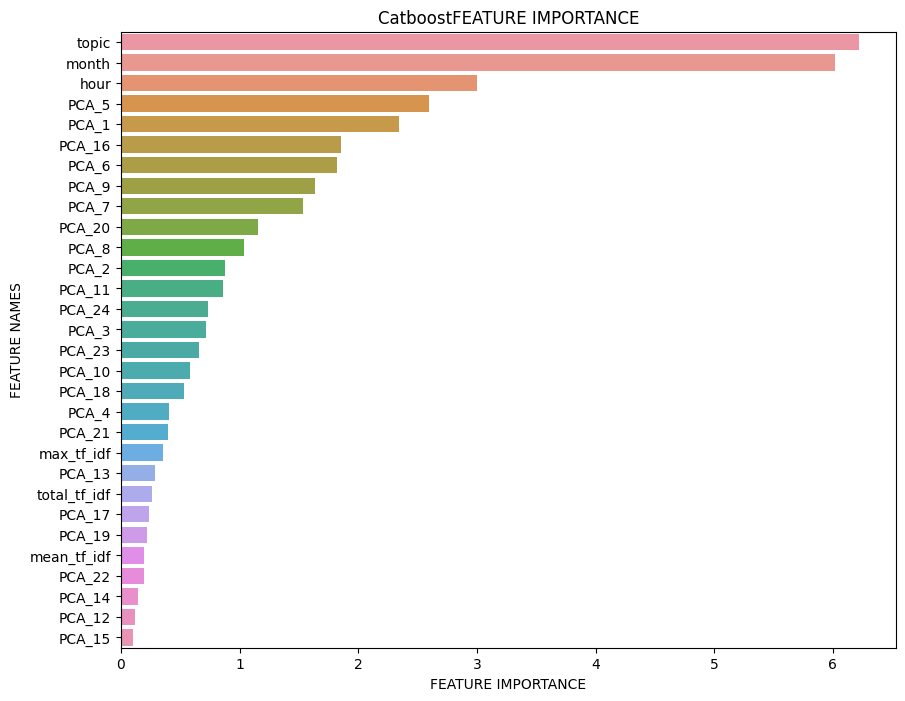

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)[:30]
    feature_names = np.array(names)[:30]

    data = {'feature_importance': feature_importance,
           'feature_names': feature_names}

    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by='feature_importance', ascending=False, inplace=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(base_model.feature_importances_, X_train.columns, 'Catboost')